In [49]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_columns = None
retrain_3_classes_autobalance = False
retrain_2_classes_autobalance = True
retrain_2_classes_autobalance_influenceable_features = False
retrain_up_down_sampling = False

# Data Preprocessing and Exploring

In [50]:
acc = pd.read_csv('./data/Accident_Information.csv', encoding = 'latin')
veh = pd.read_csv('./data/Vehicle_Information.csv', encoding = 'latin')
df_boroughs = gpd.read_file('./data/london_boroughs.json')
london_boroughs= df_boroughs.name

C:\Users\henninta\AppData\Local\Temp\ipykernel_11364\2147360756.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  acc = pd.read_csv('./data/Accident_Information.csv', encoding = 'latin')


Check if all boroughs are in the 'Local_Authority_(District)' column present.

In [51]:
acc_boroughs = acc.groupby('Local_Authority_(District)')['Accident_Index'].nunique()
b_in = 0
b_out = 0 
for b in london_boroughs:
    if b in acc_boroughs.index:
        b_in = b_in +1
    else:
         b_out =  b_out+1
print(len(london_boroughs))
print(b_in)
print(b_out)

33
33
0


filter for accidents in the boroughs of london

In [52]:
acc_london = acc[acc['Local_Authority_(District)'].isin(london_boroughs)]

Next I changed the Dates to Datetime and generated new Daytime feature as follows:
Morning Rush from 5am to 10am
Office Hours from 10am to 3pm (or: 10:00 - 15:00)
Afternoon Rush from 3pm to 7pm (or: 15:00 - 19:00)
Evening from 7pm to 11pm (or: 19:00 - 23:00)
Night from 11pm to 5am (or: 23:00 - 05:00)


In [53]:
acc_london['Date']= pd.to_datetime(acc_london['Date'], format="%Y-%m-%d")

# slice first and second string from time column
acc_london['Hour'] = acc_london['Time'].str[0:2]
# convert new column to numeric datetype
acc_london['Hour'] = pd.to_numeric(acc_london['Hour'])
# drop null values in our new column
accidents = acc_london.dropna(subset=['Hour'])
# cast to integer values
accidents['Hour'] = accidents['Hour'].astype('int')

def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "morning rush (5-10)"
    elif hour >= 10 and hour < 15:
        return "office hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "afternoon rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "evening (19-23)"
    else:
        return "night (23-5)"

acc_london['Daytime'] = acc_london['Hour'].apply(when_was_it)
# drop old time column and temporary hour column
acc_london = acc_london.drop(columns=['Time', 'Hour'])

C:\Users\henninta\AppData\Local\Temp\ipykernel_11364\2510168215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_london['Date']= pd.to_datetime(acc_london['Date'], format="%Y-%m-%d")
C:\Users\henninta\AppData\Local\Temp\ipykernel_11364\2510168215.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_london['Hour'] = acc_london['Time'].str[0:2]
C:\Users\henninta\AppData\Local\Temp\ipykernel_11364\2510168215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Next up lets look at the year distribution and severity distribution 

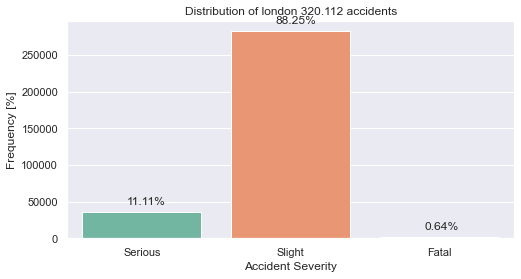

In [54]:
import seaborn as sns
# severity distribution
ax = sns.countplot(x = acc_london.Accident_Severity ,palette="Set2")
sns.set(font_scale=1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(acc_london.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of london 320.112 accidents',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()

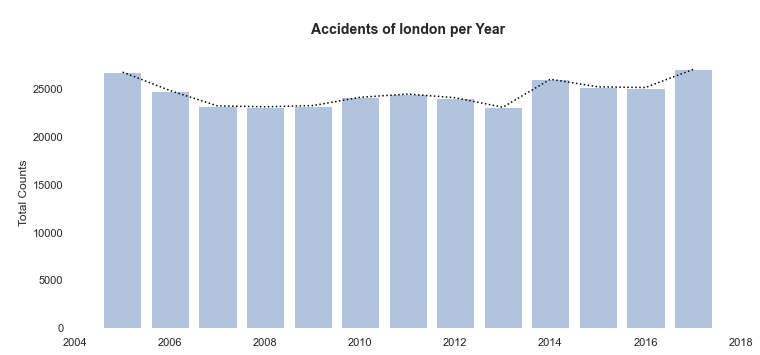

In [55]:
yearly_count = acc_london['Year'].value_counts().sort_index(ascending=False)

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,5))

# plot
ax.bar(yearly_count.index, yearly_count.values, color='lightsteelblue')
ax.plot(yearly_count, linestyle=':', color='black')
ax.set_title('\nAccidents of london per Year\n', fontsize=14, fontweight='bold')
ax.set(ylabel='\nTotal Counts')

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

Nextup, lets check for missing values on the acc_london dataframe.

In [56]:
print('Proportion of Missing Values in Accidents Table:', 
      round(acc_london.isna().sum().sum()/len(acc_london),3), '%')

Proportion of Missing Values in Accidents Table: 0.273 %


<AxesSubplot:>

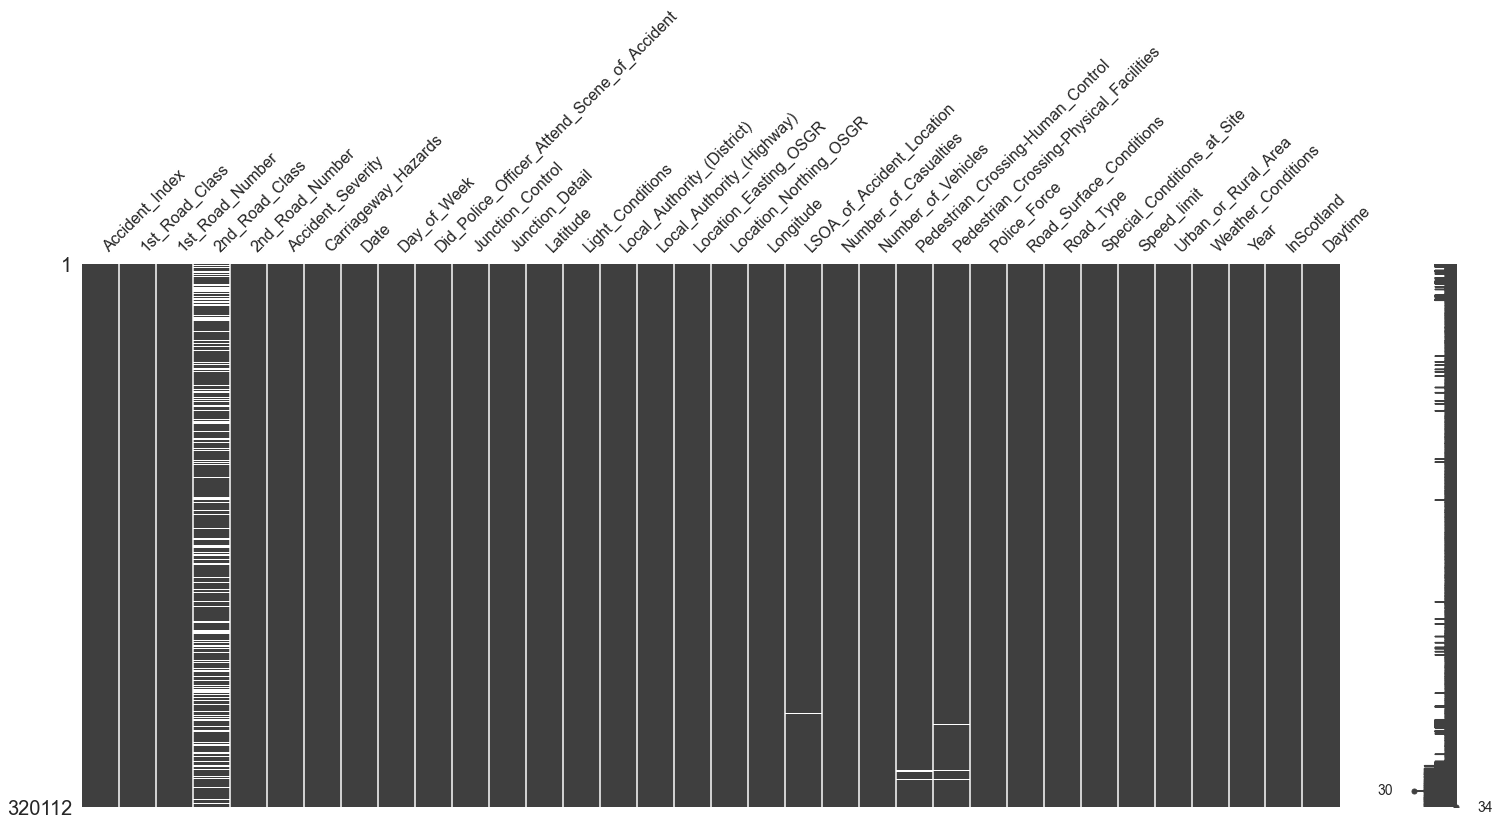

In [57]:
import missingno as msno
msno.matrix(acc_london)

As only the column "2nd_Road_Class" has a lot of missing values and only a few rows containing any missing values, i droped those to save me some time.
Some could also use imputation-technics to fill the missing values.

<AxesSubplot:>

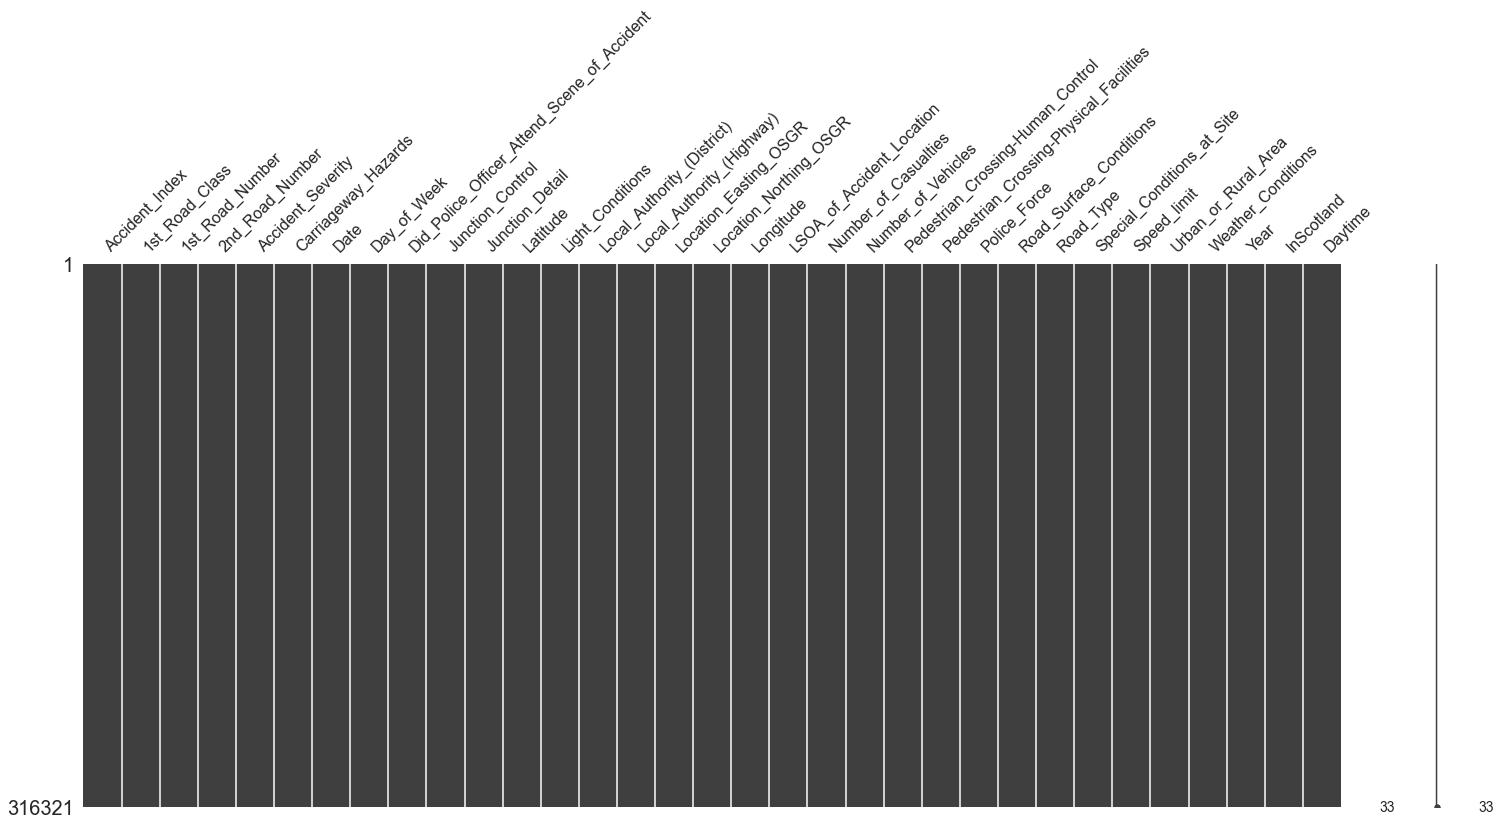

In [58]:
acc_london = acc_london.drop('2nd_Road_Class', axis=1)
c_acc_london = acc_london.dropna()
msno.matrix(c_acc_london)

In [59]:
print('Proportion of Missing Values in Accidents Table:', 
      round(c_acc_london.isna().sum().sum()/len(c_acc_london),3), '%')
print("cleand data len",len(c_acc_london))
print("cleand data len", len(acc_london))


Proportion of Missing Values in Accidents Table: 0.0 %
cleand data len 316321
cleand data len 320112


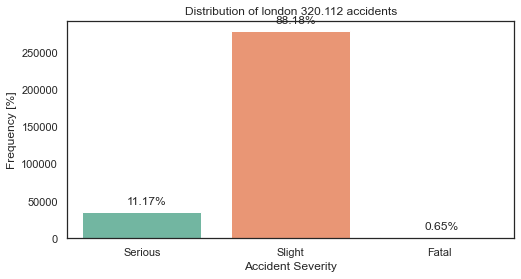

In [60]:
ax = sns.countplot(x = c_acc_london.Accident_Severity ,palette="Set2")
sns.set(font_scale=1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(c_acc_london.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of london 320.112 accidents',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()

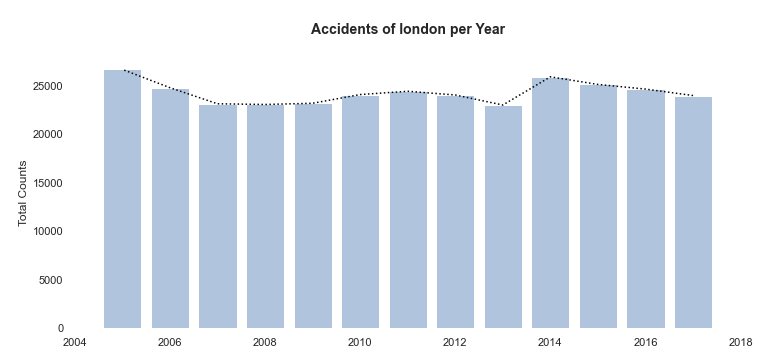

In [61]:
yearly_count = c_acc_london['Year'].value_counts().sort_index(ascending=False)

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,5))

# plot
ax.bar(yearly_count.index, yearly_count.values, color='lightsteelblue')
ax.plot(yearly_count, linestyle=':', color='black')
ax.set_title('\nAccidents of london per Year\n', fontsize=14, fontweight='bold')
ax.set(ylabel='\nTotal Counts')

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

In [62]:
print(c_acc_london.groupby('Accident_Severity')['Accident_Index'].nunique())


Accident_Severity
Fatal        2041
Serious     35343
Slight     278937
Name: Accident_Index, dtype: int64


The distribution of the classes and years still stays the same.
Now we I join the vehicle data to the accident data and look at the missing values of the vehicle data.
Next i checked for the the datatypes of the columns and transformed 'object's to 'category' type.

Next I split the features and target column and fill in missing values with the categorical representation of 'missing'.

In [63]:
# Merging two data sets into one with inner join by index
df = pd.merge(c_acc_london,veh, how = 'inner', on = 'Accident_Index')

#Check data sample
print(df.shape)
print(c_acc_london.shape)
print(c_acc_london.columns)

(308198, 56)
(316321, 33)
Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'LSOA_of_Accident_Location', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
       'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Year',
       'InScotland', 'Daytime'],
      dtype='object')


<AxesSubplot:>

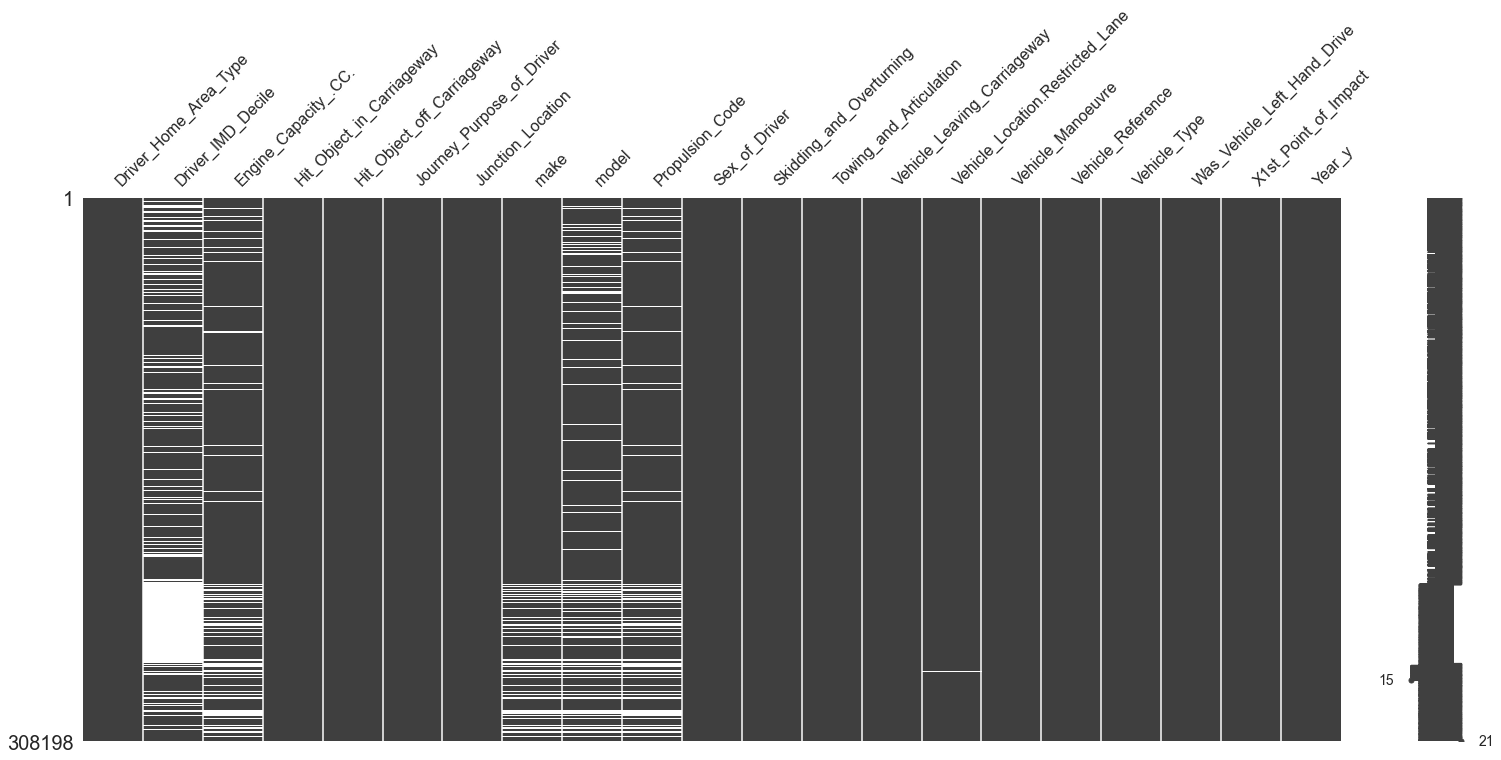

In [64]:
msno.matrix(df.iloc[:,35:])


In [65]:
print('Proportion of Missing Values in complete table:', 
      round(df.isna().sum().sum()/len(df),3), '%')

Proportion of Missing Values in complete table: 1.049 %


In [66]:
# define our features 
features = df.drop(['Accident_Severity','Accident_Index', 'Date'], axis=1) #,'Accident_Index','Time'
# define our target
target = df[['Accident_Severity']]


c_index = []
c_coloumn = []

index = 0
for c in features:
    if features[c].dtypes == 'object':
        features[c] = features[c].astype('category')
        #print("converted: ",c)
        c_index.append(index)
        c_coloumn.append(c)
    index += 1

features['make'] = features['make'].cat.add_categories("None").fillna("None")
features['model'] = features['model'].cat.add_categories("None").fillna("None")
features['Propulsion_Code'] = features['Propulsion_Code'].cat.add_categories("None").fillna("None")



# define only influenceable features for different model
features_influenceable = features.drop(['Day_of_Week','Daytime', 'Year_x','Year_y','Longitude','Latitude'], axis=1) 
cat_features_features_influenceable = []
index = 0
for c in features_influenceable:
    if features_influenceable[c].dtypes == 'object' or features_influenceable[c].dtypes == 'category':
        cat_features_features_influenceable.append(index)
    index += 1

In [67]:
features.dtypes
for c in features:
    print(c)
    print(features[c].dtypes)
    print("unique values: " ,len(features[c].unique()))
    print(features[c].unique()[0:10])

1st_Road_Class
category
unique values:  5
['B', 'C', 'A', 'Unclassified', 'Motorway']
Categories (5, object): ['A', 'B', 'C', 'Motorway', 'Unclassified']
1st_Road_Number
float64
unique values:  418
[ 450.    0. 3220.  315.    4. 3217. 3218.  302.  319.  402.]
2nd_Road_Number
float64
unique values:  415
[0.000e+00 3.250e+02 3.080e+02 3.216e+03 4.000e+00 3.190e+02 3.218e+03
 4.204e+03 3.217e+03 3.220e+03]
Carriageway_Hazards
category
unique values:  7
['None', 'Other object on road', 'Pedestrian in carriageway - not injured', 'Vehicle load on road', 'Previous accident', 'Any animal in carriageway (except ridden horse)', 'Data missing or out of range']
Categories (7, object): ['Any animal in carriageway (except ridden horse)', 'Data missing or out of range', 'None', 'Other object on road', 'Pedestrian in carriageway - not injured', 'Previous accident', 'Vehicle load on road']
Day_of_Week
category
unique values:  7
['Wednesday', 'Thursday', 'Friday', 'Monday', 'Tuesday', 'Sunday', 'Saturda

Next prepare training and test data for different kind of models.
I am always using a random state, that the result is reproducable.
Also i use the stratify option, so that my class label has the same distribution in the test and training set.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

# data for 3 class classification
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=11, shuffle=True, stratify=target.Accident_Severity)
X_train.to_pickle('./data/X_train.pkl')
X_test.to_pickle('./data/X_test.pkl')
y_train.to_pickle('./data/y_train.pkl')
y_test.to_pickle('./data/y_test.pkl')


# data for up- and down-sampling approach
X_train_updownsampling, X_test_updownsampling, y_train_updownsampling, y_test_updownsamplingtest = train_test_split(features, target, test_size=0.2, random_state=11, shuffle=True, stratify=target.Accident_Severity)


# data for 2 class classification
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features, target, test_size=0.2, random_state=11, shuffle=True, stratify=target.Accident_Severity)
y_train_2['Accident_Severity'] = np.where(y_train_2['Accident_Severity']=='Slight', 0, 1) 
y_test_2['Accident_Severity'] = np.where(y_test_2['Accident_Severity']=='Slight', 0, 1) 

X_train_2.to_pickle('./data/X_train_2.pkl')
X_test_2.to_pickle('./data/X_test_2.pkl')
y_train_2.to_pickle('./data/y_train_2.pkl')
y_test_2.to_pickle('./data/y_test_2.pkl')

# data for 2 class classification, but only influenceable features
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features_influenceable, target, test_size=0.2, random_state=11, shuffle=True, stratify=target.Accident_Severity)
y_train_3['Accident_Severity'] = np.where(y_train_3['Accident_Severity']=='Slight', 'Slight', 'Serious or Fatal') 
y_test_3['Accident_Severity'] = np.where(y_test_3['Accident_Severity']=='Slight', 'Slight', 'Serious or Fatal') 

X_train_3.to_pickle('./data/X_train_3.pkl')
X_test_3.to_pickle('./data/X_test_3.pkl')
y_train_3.to_pickle('./data/y_train_3.pkl')
y_test_3.to_pickle('./data/y_test_3.pkl')



import pickle
with open('./data/cat_features.pkl', 'wb') as b:
    pickle.dump(c_index,b)


with open('./data/cat_features_features_influenceable.pkl', 'wb') as b:
    pickle.dump(cat_features_features_influenceable,b)



In [69]:
print(y_train.Accident_Severity.value_counts(normalize=True))
print(y_test.Accident_Severity.value_counts(normalize=True))

Slight     0.903033
Serious    0.091236
Fatal      0.005731
Name: Accident_Severity, dtype: float64
Slight     0.903034
Serious    0.091239
Fatal      0.005727
Name: Accident_Severity, dtype: float64


# Modeling

I tried two different methods for handaling the unbalanced data classes.

## Up- and Down-Sampling
First I tried the up- and downsampling. For the 3 class problem, I upsampled the minority class ('Fatal') to the level of the middle class ('Serious'), and downsampled the majority class ('Slight') to the level of the middle class. For the upsampling i created new synthetic data by the SMOTE method. As we do not only have numerical data, we also have categorical data, we can use an adaptaion, the SMOTENC method.
SMOTENC is a Synthetic Minority Over-sampling Technique for Nominal and Continuous. SMOTENC can not handle null values in our data, therefore we have to impute the null values first. For numerical missing values, we use the placeholder -1.

First lets look at the current distribution of the classes in the train set.


## Balanced Auto Class Weights

I also did model training with the auto_class_weights of catboost.

## Up- and Down-Sampling

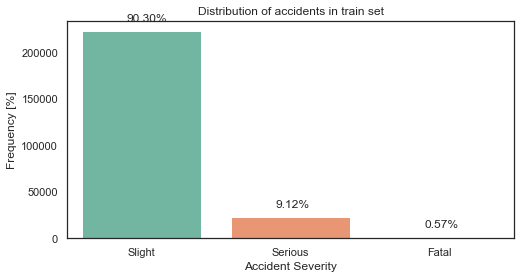

In [70]:
ax = sns.countplot(x = y_train_updownsampling.Accident_Severity,palette="Set2")
sns.set(font_scale=1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(y_train_updownsampling.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of accidents in train set',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()

In [71]:
X_train_updownsampling.Age_of_Vehicle = X_train_updownsampling.Age_of_Vehicle.fillna(-1)
X_train_updownsampling.Driver_IMD_Decile = X_train_updownsampling.Driver_IMD_Decile.fillna(-1)
X_train_updownsampling['Engine_Capacity_.CC.'] =X_train_updownsampling['Engine_Capacity_.CC.'].fillna(-1)
X_train_updownsampling['Vehicle_Location.Restricted_Lane'] =X_train_updownsampling['Vehicle_Location.Restricted_Lane'].fillna(-1)

X_train_updownsampling.Age_of_Vehicle = X_train_updownsampling.Age_of_Vehicle.fillna(-1)
X_train_updownsampling.Driver_IMD_Decile = X_train_updownsampling.Driver_IMD_Decile.fillna(-1)
X_train_updownsampling['Engine_Capacity_.CC.'] =X_train_updownsampling['Engine_Capacity_.CC.'].fillna(-1)
X_train_updownsampling['Vehicle_Location.Restricted_Lane'] =X_train_updownsampling['Vehicle_Location.Restricted_Lane'].fillna(-1)

Next we need to provide a list of indices where the categorical values are.

In [72]:
X_train_sub_1 = X_train_updownsampling[y_train_updownsampling.Accident_Severity.isin(['Serious','Fatal'])]
y_train_sub_1 = y_train_updownsampling[y_train_updownsampling.Accident_Severity.isin(['Serious','Fatal'])]
X_train_sub_2 = X_train_updownsampling[y_train_updownsampling.Accident_Severity.isin(['Slight'])]
y_train_sub_2 = y_train_updownsampling[y_train_updownsampling.Accident_Severity.isin(['Slight'])]

In [73]:
from imblearn.over_sampling import SMOTENC
X_resampled, y_resampled = SMOTENC(categorical_features=c_index, random_state=0).fit_resample(X_train_sub_1, y_train_sub_1)

After applying the SMOTENC method we now have 22597 data points for the fatal class as well.

In [74]:
y_resampled.value_counts().to_frame().T

Accident_Severity,Fatal,Serious
0,22495,22495


Next we downsample the majority class, so that we have the balanced dataset

In [75]:
train_sub_1 = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)
train_sub_2 = pd.merge(X_train_sub_2, y_train_sub_2, left_index=True, right_index=True)
undersample = pd.concat([train_sub_1, 
                         train_sub_2.sample(frac=0.10, random_state=42)])


# now randomly shuffle the dataframe rows in order to mix up the classes again
undersample = undersample.sample(frac=1, random_state=42)

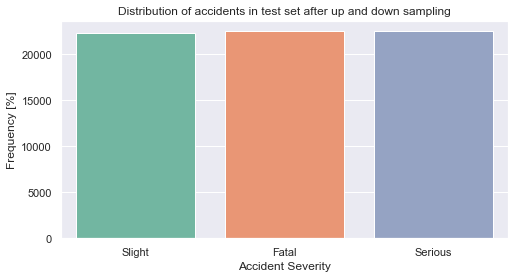

In [76]:
ax = sns.countplot(x = undersample.Accident_Severity,palette="Set2")
sns.set(font_scale=1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(undersample.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of accidents in test set after up and down sampling',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()

Now lets train a second catboost model on the balanced training data and see how it performs on the test data.

In [77]:
features_up_down_sampling = undersample.drop(['Accident_Severity',], axis=1) 
target_up_down_sampling = undersample[['Accident_Severity']]

cat_features_up_down_sampling = []

index = 0
for c in features_up_down_sampling:
    if features_up_down_sampling[c].dtypes == 'category':
        cat_features_up_down_sampling.append(index)
    index += 1

## Training

In [78]:
from catboost import Pool, CatBoostClassifier


params_up_down_sampling = {
    'random_state': 42,
    'verbose': 5,
    "eval_metric" : 'TotalF1',
    }

params_autobalance_3_classes = {
        'leaf_estimation_method': 'Gradient',
        # 'learning_rate': 0.01,
        # 'max_depth': 8,
        # 'bootstrap_type': 'Bernoulli',
        # 'objective': 'MultiClass',
        # 'subsample': 0.8,
        'random_state': 42,
        'verbose': 5,
        "eval_metric" : 'TotalF1',
        # "early_stopping_rounds" : 100,
        'auto_class_weights' :'Balanced',
        }

params_autobalance_2_classes = {
        'leaf_estimation_method': 'Gradient',
        'random_state': 42,
        'verbose': 5,
        "eval_metric" : 'F1',
        'auto_class_weights' :'Balanced',
        }

cat_features_full = c_index

train_dataset_up_down_sampling = Pool(data=features_up_down_sampling,
                     label=target_up_down_sampling,
                     cat_features=cat_features_up_down_sampling)

train_dataset_1 = Pool(data=X_train,
                    label=y_train,
                    cat_features=cat_features_full)

eval_dataset_1 = Pool(data=X_test,
                    label=y_test,
                    cat_features=cat_features_full)


train_dataset_2 = Pool(data=X_train_2,
                    label=y_train_2,
                    cat_features=cat_features_full)


train_dataset_3 = Pool(data=X_train_3,
                    label=y_train_3,
                    cat_features=cat_features_features_influenceable)


if retrain_up_down_sampling:
    model_0 = CatBoostClassifier(**params_up_down_sampling)
    # Fit model
    model_0.fit(train_dataset_up_down_sampling, plot=True)
    model_0.save_model('./models/catboost_downsampling',
            format="cbm",
            export_parameters=None,
            pool=None)
else:
    model_0 = CatBoostClassifier(**params_up_down_sampling)
    model_0.load_model('./models/catboost_downsampling')


# train first model: 3 classes and auto balancing of catboost
if retrain_3_classes_autobalance:
    # Initialize CatBoostClassifier
    
    model_1 = CatBoostClassifier(**params_autobalance_3_classes)
    # Fit model
    model_1.fit(train_dataset_1, plot=True)
    model_1.save_model('./models/catboost_3_classes_autobalance',
            format="cbm",
            export_parameters=None,
            pool=None)
else:
    model_1 = CatBoostClassifier(**params_autobalance_3_classes)
    model_1.load_model('./models/catboost_3_classes_autobalance')


if retrain_2_classes_autobalance:
   
    model_2 = CatBoostClassifier(**params_autobalance_2_classes)
    # Fit model
    model_2.fit(train_dataset_2, plot=True)
    model_2.save_model('./models/catboost_2_classes_autobalance',
            format="cbm",
            export_parameters=None,
            pool=None)
else:
    model_2 = CatBoostClassifier(**params_autobalance_2_classes)
    model_2.load_model('./models/catboost_2_classes_autobalance')



if retrain_2_classes_autobalance_influenceable_features:
    model_3 = CatBoostClassifier(**params_autobalance_2_classes)
    # Fit model
    model_3.fit(train_dataset_3, plot=True)
    model_3.save_model('./models/catboost_2_classes_autobalance_influenceable_features',
                format="cbm",
                export_parameters=None,
                pool=None)
else:
    model_3 = CatBoostClassifier(**params_autobalance_2_classes)
    model_3.load_model('./models/catboost_2_classes_autobalance_influenceable_features')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6025819	total: 692ms	remaining: 11m 30s
5:	learn: 0.6190529	total: 4.62s	remaining: 12m 46s
10:	learn: 0.6197194	total: 9.07s	remaining: 13m 35s
15:	learn: 0.6218462	total: 13.4s	remaining: 13m 43s
20:	learn: 0.6369611	total: 17.7s	remaining: 13m 43s
25:	learn: 0.6675291	total: 22.8s	remaining: 14m 13s
30:	learn: 0.6764586	total: 27.2s	remaining: 14m 11s
35:	learn: 0.6769722	total: 32.5s	remaining: 14m 30s
40:	learn: 0.6815628	total: 36.9s	remaining: 14m 23s
45:	learn: 0.6845332	total: 41.5s	remaining: 14m 20s
50:	learn: 0.6859346	total: 45.4s	remaining: 14m 5s
55:	learn: 0.6858361	total: 49.2s	remaining: 13m 50s
60:	learn: 0.6899913	total: 54.1s	remaining: 13m 52s
65:	learn: 0.6924020	total: 58.1s	remaining: 13m 42s
70:	learn: 0.6937777	total: 1m 2s	remaining: 13m 38s
75:	learn: 0.6937921	total: 1m 6s	remaining: 13m 27s
80:	learn: 0.6947335	total: 1m 11s	remaining: 13m 26s
85:	learn: 0.6953383	total: 1m 14s	remaining: 13m 16s
90:	learn: 0.6945088	total: 1m 19s	remaining: 1

## Performance

Now lets look at the performance of the models:
We look at the weighted avg for the f1 score. The weighted avg accounts for class imbalance by computing the average of binary metrics weighted by the number of samples of each class in the target. 

Model 0 - up_down_sampling:
The train weighted avg f1 score is: 0.94
The test weighted avg f1 score is: 0.77

Model 1 - 3_classes_autobalance:
The train weighted avg f1 score is: 0.84
The test weighted avg f1 score is: 0.78

Model 2 - 2_classes_autobalance:
The train weighted avg f1 score is: 0.88
The test weighted avg f1 score is: 0.80

Model 3 - 2_classes_autobalance_influenceable_features:
The train weighted avg f1 score is: 0.81
The test weighted avg f1 score is: 0.77


The model with the best test f1 score of 0.8 which we will use in the following workbooks is the model on 2 classes and using the catboost auto balancing 

In [79]:
preds_class = model_0.predict(train_dataset_up_down_sampling)
report = classification_report(target_up_down_sampling, preds_class)
print('Classification Report: train metrics model_0: \n', report)

Classification Report: train metrics model_0: 
               precision    recall  f1-score   support

       Fatal       0.99      1.00      1.00     22495
     Serious       0.86      0.98      0.92     22495
      Slight       0.99      0.83      0.90     22265

    accuracy                           0.94     67255
   macro avg       0.94      0.94      0.94     67255
weighted avg       0.94      0.94      0.94     67255



In [80]:
preds_class = model_0.predict(Pool(data=X_test_updownsampling,
                     label=y_test_updownsamplingtest,
                     cat_features=cat_features_up_down_sampling))
report = classification_report(y_test_updownsamplingtest, preds_class)
print('Classification Report: test metrics model_0: \n', report)

Classification Report: test metrics model_0: 
               precision    recall  f1-score   support

       Fatal       0.09      0.11      0.10       353
     Serious       0.21      0.75      0.33      5624
      Slight       0.97      0.71      0.82     55663

    accuracy                           0.71     61640
   macro avg       0.42      0.52      0.41     61640
weighted avg       0.89      0.71      0.77     61640



In [81]:
preds_class = model_1.predict(train_dataset_1)
report = classification_report(y_train, preds_class)
print('Classification Report: train metrics model_1: \n', report)

Classification Report: train metrics model_1: 
               precision    recall  f1-score   support

       Fatal       0.10      1.00      0.19      1413
     Serious       0.35      0.93      0.51     22495
      Slight       1.00      0.78      0.87    222650

    accuracy                           0.79    246558
   macro avg       0.48      0.90      0.52    246558
weighted avg       0.93      0.79      0.84    246558



In [82]:
preds_class = model_1.predict(eval_dataset_1)
report = classification_report(y_test, preds_class)
print('Classification Report: test metrics model_1: \n', report)

Classification Report: test metrics model_1: 
               precision    recall  f1-score   support

       Fatal       0.06      0.72      0.12       353
     Serious       0.23      0.65      0.34      5624
      Slight       0.97      0.72      0.83     55663

    accuracy                           0.71     61640
   macro avg       0.42      0.70      0.43     61640
weighted avg       0.90      0.71      0.78     61640



In [83]:
preds_class = model_2.predict(train_dataset_2)
report = classification_report(y_train_2, preds_class)
print('Classification Report: train metrics model_2: \n', report)

Classification Report: train metrics model_2: 
               precision    recall  f1-score   support

           0       1.00      0.85      0.92    222650
           1       0.42      0.99      0.59     23908

    accuracy                           0.86    246558
   macro avg       0.71      0.92      0.75    246558
weighted avg       0.94      0.86      0.89    246558



In [84]:
preds_class = model_2.predict(Pool(data=X_test_2,
                    label=y_test_2,
                    cat_features=cat_features_full))
report = classification_report(y_test_2, preds_class)
print('Classification Report: test metrics model_2: \n', report)

Classification Report: test metrics model_2: 
               precision    recall  f1-score   support

           0       0.97      0.76      0.85     55663
           1       0.25      0.78      0.38      5977

    accuracy                           0.76     61640
   macro avg       0.61      0.77      0.62     61640
weighted avg       0.90      0.76      0.80     61640



In [85]:
preds_class = model_3.predict(train_dataset_3)
report = classification_report(y_train_3, preds_class)
print('Classification Report: train metrics model_3: \n', report)

Classification Report: train metrics model_3: 
                   precision    recall  f1-score   support

Serious or Fatal       0.29      0.94      0.44     23908
          Slight       0.99      0.75      0.85    222650

        accuracy                           0.77    246558
       macro avg       0.64      0.84      0.65    246558
    weighted avg       0.92      0.77      0.81    246558



In [86]:
preds_class = model_3.predict(Pool(data=X_test_3,
                    label=y_test_3,
                    cat_features=cat_features_features_influenceable))
report = classification_report(y_test_3, preds_class)
print('Classification Report: test metrics model_3: \n', report)

Classification Report: test metrics model_3: 
                   precision    recall  f1-score   support

Serious or Fatal       0.21      0.73      0.33      5977
          Slight       0.96      0.71      0.81     55663

        accuracy                           0.71     61640
       macro avg       0.59      0.72      0.57     61640
    weighted avg       0.89      0.71      0.77     61640

